In [1]:
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import binom
import numpy as np

np.set_printoptions(legacy='1.25')

fig_directory = '../../Note/Notes/Figures/03_rdn_net/'

# Random models

## Erdos-Renyi random graph

We consider an instance of the Erdos-Renyi model with $n$ nodes and connection probability equal to $p$. We first compare the empirical degree distribution with the theoretical prediction.

### Degree distribution

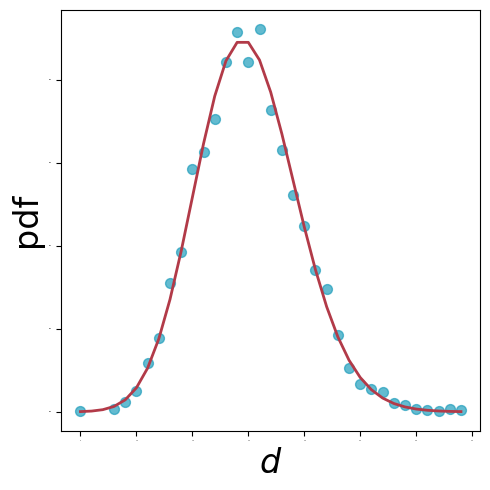

In [7]:
# Generate an instance of the ER random graph
n = 5000  # Number of nodes
p = 20/n  # Connection probability
g = nx.erdos_renyi_graph(n, p)

# Compute the degree distribution
degree_counts = Counter(dict(g.degree()).values())

# Normalize the distribution
degree_probabilities = {k: v/n for k, v in degree_counts.items()}

# Theoretical binomial distribution
degree_range = np.arange(min(degree_counts.keys()), max(degree_counts.keys()) + 1)
binomial_pmf = [binom.pmf(k, n - 1, p) for k in degree_range]


fig, ax = plt.subplots(1,1, figsize = (5,5))

ax.plot(degree_range, binomial_pmf, color = '#b23a48', linewidth = 2)
ax.scatter(degree_probabilities.keys(), degree_probabilities.values(), s = 50, color = '#219ebc', alpha = 0.7)
ax.set_xlabel(r'$d$', fontsize = 24)
ax.set_ylabel('pdf', fontsize = 24)
ax.tick_params(axis='both', which='major', labelsize = 0)

plt.tight_layout()
# plt.savefig(f'{fig_directory}poisson.pdf', bbox_inches = 'tight', dpi = 400)

plt.show();

### Global clustering coefficient

We then compare the global clustering coefficient measured in the network with the theoretical expectation. Note that the global clustering coefficient is also named `transitivity` in the literature and this is the nomenclature used by NetworkX. The expected value of the global clustering coefficient is $p$, the connection probability.

In [8]:
print(f'Global clustering coefficient: {nx.transitivity(g)}')
print(f'p: {p}')

Global clustering coefficient: 0.0039017007336556928
p: 0.004


### Emergence of a giant component

We now empirically verify the percolation threshold. We expect the size of the largest connected component to vanish with resepct to $n$ if the connecting probability $p< \frac{1}{n}$, i.e. if the expected average degree is smaller than one. We then generate a sequence of random graphs from the Erdos-Renyi model, with varying average degree and compute the relative size of the largest connected component.

In [9]:
n = 5000
S = []
dv = np.linspace(0.1, 3, 15)

for i, d in enumerate(dv):
    print(f'i: {i+1}/{len(dv)}', end = '\r')
    g = nx.erdos_renyi_graph(n,d/n)
    S.append(len(max(nx.connected_components(g), key = len))/n)

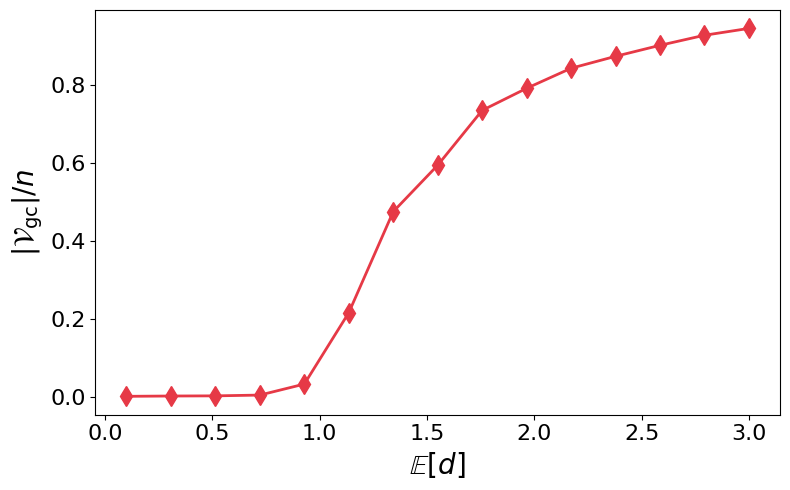

In [10]:
fig, ax = plt.subplots(1,1, figsize = (8,5))
ax.plot(dv, S, color = '#e63946', linewidth = 2, markersize = 10, marker = 'd')
ax.set_xlabel(r'$\mathbb{E}[d]$', fontsize = 20)
ax.set_ylabel(r'$|\mathcal{V}_{\rm gc}|/n$', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize = 16)


plt.tight_layout()
# plt.savefig(f'{fig_directory}percolation.pdf', bbox_inches = 'tight', dpi = 400)

plt.show();


## Configuration model

We now repeate the steps above with the configuration model. We consider the $\bm{\theta}$ as a (properly rescaled) vector drawn from an exponential distribution.

In [11]:
n = 5000

# generate a vector theta (we use the exponential distribution in this case)
theta = np.random.exponential(scale = 20, size = n)
theta = theta/np.mean(theta)

# set the average degree
deg = 10

# generate the graph
g = nx.expected_degree_graph(theta*deg)

### Degree distribution

The expected degree of each node is $\mathbb{E}[d_i] = np\theta_i$, hence the degree distribution closely follows the degree of $\bm{\theta}$.

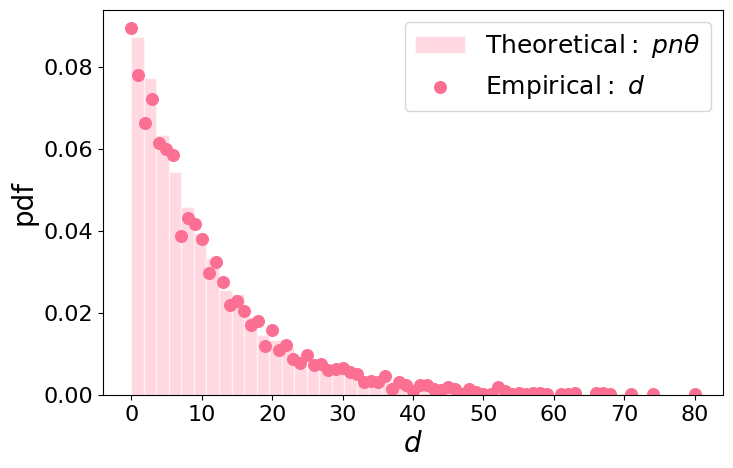

The average degree is 10.0832


In [13]:
fig, ax = plt.subplots(1,1, figsize = (8,5))
deg_dict = Counter(dict(g.degree()).values())

ax.hist(theta*deg, density = True, bins = 40, alpha = 0.5, edgecolor = 'white', label = r'${\rm Theoretical:~}pn\theta$', color = '#ffb3c6')
ax.scatter(deg_dict.keys(), np.array(list(deg_dict.values()))/n, s = 70, label = r'${\rm Empirical:}~d$', color = '#fb6f92')
ax.legend(fontsize = 18)
ax.set_xlabel(r'$d$', fontsize = 20)
ax.set_ylabel(r'pdf', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize = 16)
plt.show();

print(f'The average degree is {2*len(g.edges)/n}')

### Global clustering coefficient

The global clustering coefficient in this case is $p\Phi$, where $\Phi = \langle \theta^2\rangle$, which degrermines the degree heterogeneity.

In [14]:
print(f'Global clustering coefficient: {nx.transitivity(g)}')
phi = np.mean(theta**2)
print(f'p: {p*phi}')

Global clustering coefficient: 0.008101307878061034
p: 0.007832847586532427


## Stochastic block model

We generate an instance of the stochastic block model (without degree correction) with $k=2$ communities and a strong assortative structure. We then plot the graph using the node labels as color and marker code. Note that the visualization depends on the position in which the nodes are placed that is computed with the function `spring_layout`. This is a function (quite computationally expensive) that simulates a situation in which all nodes are connected by springs and finds the configuration with the smallest energy.

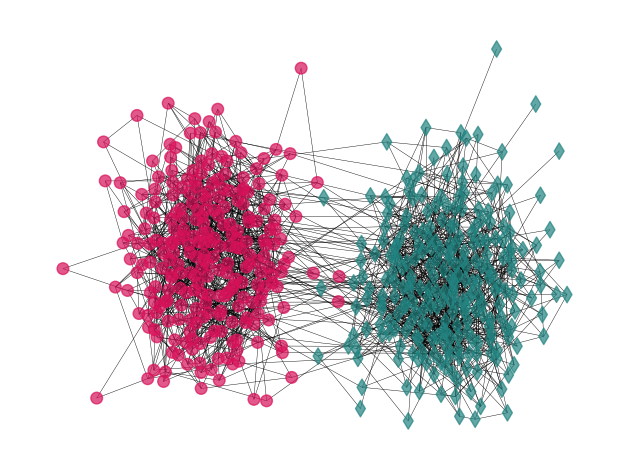

In [15]:
n = 500
sizes = [int(n/2), int(n/2)]
c_in, c_out = 15., .5
probs = [[c_in/n, c_out/n], [c_out/n, c_in/n]]
label = np.zeros(n)
label[int(n/2):] = 1
label = label.astype(int)

g = nx.stochastic_block_model(sizes, probs)
GC = list(max(nx.connected_components(g), key = len))
g_ = nx.subgraph(g, max(nx.connected_components(g), key = len))


colors_ = ["d81159","218380"]
shapes_ = ['o', 'd']
colors_ = [f'#{v}' for v in colors_]
colors = np.array([colors_[label[i]] for i in range(n)])
colors = colors[GC]

shapes = np.array([shapes_[label[i]] for i in range(n)])
shapes = shapes[GC]

# Get node positions for plotting
pos = nx.spring_layout(g_)

# Draw edges first
nx.draw_networkx_edges(g_, pos, edge_color='k', width=0.3, style='-')

for shape in set(shapes):
    nx.draw_networkx_nodes(
        g_, 
        pos, 
        nodelist=[node for node, s in zip(g.nodes(), shapes) if s == shape],
        node_color=[colors[i] for i in range(len(colors)) if shapes[i] == shape],
        node_size=70,
        node_shape=shape,
        alpha=0.7
    )

plt.axis('off')
plt.tight_layout()
# plt.savefig(f'{fig_directory}sbm.pdf', bbox_inches = 'tight', dpi = 400)
plt.show();

The modularity is defined as $\mathcal{Q}_A(\bm{\ell}) = \frac{1}{2|\mathcal{E}|}\sum_{i,j\in\mathcal{V}} \left(A_{ij} - \frac{d_id_j}{2|\mathcal{E}|}\right)\delta(\ell_i,\ell_j)$ and it quantifies the assortativity of a community partition in a network. We compute it for the graph we just generated and compare it with its expected value. Then we also compute the normalized assortativity coefficient.

In [18]:
partition = [set(np.where(label == i)[0]) for i in np.unique(label)]
print(f'Modularity: {nx.algorithms.community.modularity(g, partition)}')
c = (c_in + c_out)/2

print(f'Expected modularity: {(c_in/c - 1)/2}')

# normalized assortativty
k = len(np.unique(label))
A = nx.adjacency_matrix(g)
e = np.zeros((k,k))
for a in range(k):
    idxa = label == a
    for b in range(k):
        idxb = label == b
        e[a,b] = np.sum(A[idxa][:,idxb])/np.sum(A)

print(f'Normalized assortativity: {(np.trace(e) - np.sum(e@e))/(1-np.sum(e@e))}')

Modularity: 0.4624699233348335
Expected modularity: 0.467741935483871
Normalized assortativity: 0.9252025628700059


## Barabasi-Albert

We now generate a Barabasi-Albert graph with $n$ nodes and parameter $m$ and analyze its degree distribution and clustering coefficient, comparing them with their theoretical predictions. In particular the degree distribution follows the law $\mathbb{P}(d) \sim d^{-3}$.

In [19]:
# generate the graph
n, m = 15000, 5
g = nx.barabasi_albert_graph(n,m)

### Degree distribution

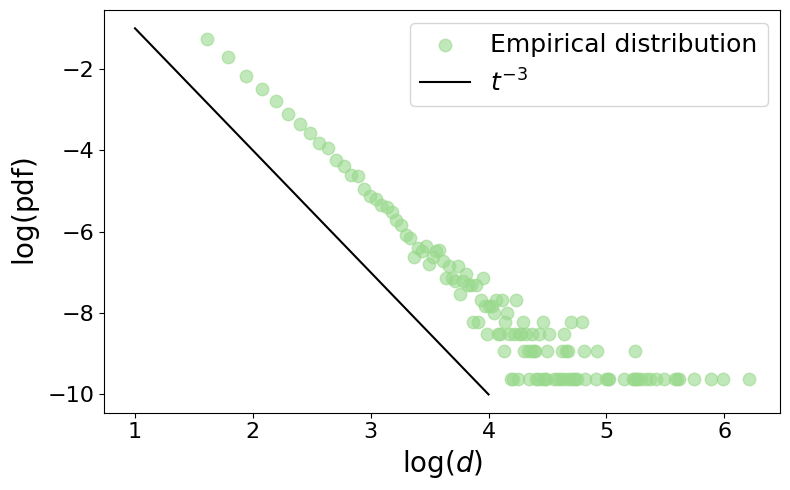

In [20]:
d = list(dict(g.degree()).values())
d_counts = Counter(d)

fig, ax = plt.subplots(1,1, figsize = (8,5))
ax.scatter(np.log(np.array(list(d_counts.keys()))), np.log(np.array(list(d_counts.values()))/n), s = 80, color = '#99d98c', alpha = 0.6, label = 'Empirical distribution')
ax.plot(np.arange(1,5), -3*np.arange(1,5)+2, color = 'k', label = r'$t^{-3}$')
ax.set_xlabel(r'${\rm log}(d)$', fontsize = 20)
ax.set_ylabel(r'${\rm log}({\rm pdf})$', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize = 16)
ax.legend(fontsize = 18)

plt.tight_layout()
# plt.savefig(f'{fig_directory}BA.pdf', bbox_inches = 'tight', dpi = 400)
plt.show();


### Clustering coefficient

The clustering coefficient grows as ${\rm log}^2(n)$, hence we create several BA networks with increasing sizes and show the global clustering coefficient as a function of $n$.

In [21]:
nv = np.linspace(10**3, 10**5, 10)
C = []

for n in nv:
    g = nx.barabasi_albert_graph(n, m)
    C.append(nx.transitivity(g))

C = np.array(C)

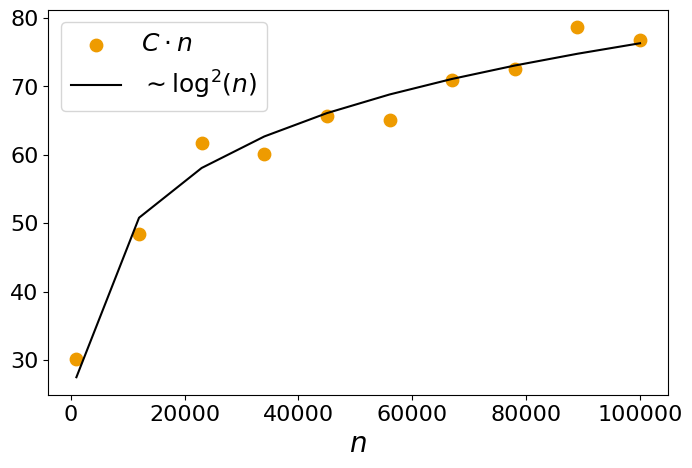

In [22]:
# fit the multiplicative constant
a = np.mean(C*nv*np.log(nv)**2)/np.mean(np.log(nv)**4)

fig, ax = plt.subplots(1,1, figsize = (8,5))

ax.scatter(nv, C*nv, color = '#ee9b00', s = 80, label = r'$C\cdot n$')
ax.plot(nv, a*np.log(nv)**2, color = 'k', label = r'$\sim {\rm log}^2(n)$')

ax.set_xlabel(r'$n$', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize = 16)
ax.legend(fontsize = 18)

plt.show();

## Watt-Strogatz

Finally, we investigate the Watts-Strogatz model. We compare its empirical degree distribution with the theoretical prediction. Then, for different values of the rewiring probability $p$, we compute the clustering coefficient and the average path length to analyze simoultaneously the behavior of these two quantities.

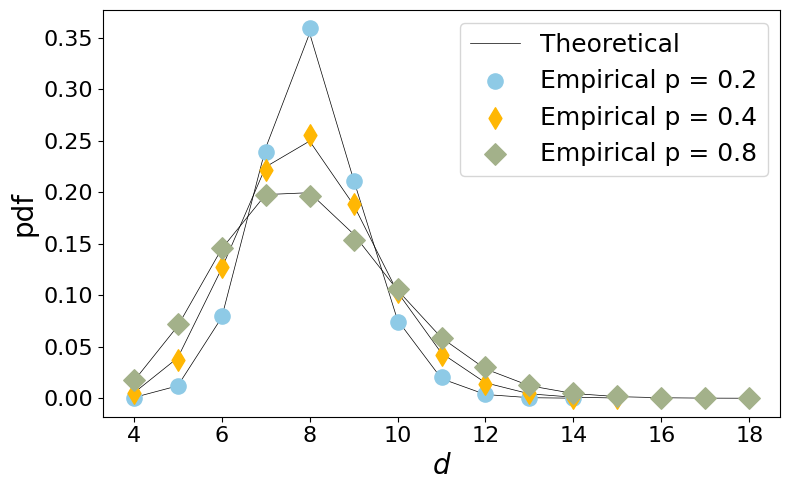

In [23]:
# function to compute the degree distribution at each point d
def WS_def_distr(d, k, p):
    S = 0
    for m in range(np.min([k, d-k])+1):
        S += binom.pmf(m, k, 1-p)*binom.pmf(d-k-m, (n-1)*k, p/(n-1))

    return S

n, k = 15000, 4

pv = [0.2, 0.4, 0.8]
colors = ['#8ecae6', '#ffb703', '#a3b18a']
markers = ['o', 'd', 'D']

fig, ax = plt.subplots(1,1, figsize = (8,5))

for i, p in enumerate(pv):
    g = nx.watts_strogatz_graph(n, 2*k, p)

    deg_dict = Counter(list(dict(g.degree()).values()))
    dv = np.sort(list(deg_dict.keys()))

    if i == 0:
        ax.plot(dv, [WS_def_distr(d, k, p) for d in dv], zorder = 0, color = 'k', linewidth = 0.5, label = 'Theoretical')
    else:
        ax.plot(dv, [WS_def_distr(d, k, p) for d in dv], zorder = 0, color = 'k', linewidth = 0.5)
    ax.scatter(deg_dict.keys(), np.array(list(deg_dict.values()))/n, s = 120, color = colors[i], zorder = 1, label = f'Empirical p = {p}', marker = markers[i])
    ax.set_xlabel(r'$d$', fontsize = 20)
    ax.set_ylabel('pdf', fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize = 16)
    ax.legend(fontsize = 18)
plt.tight_layout()

# plt.savefig(f'{fig_directory}WS_deg.pdf', bbox_inches = 'tight', dpi = 400)
plt.show();

### Clustering coefficient and APL

In [24]:
n, k = 1000, 3

pv = np.logspace(-4, 0, 25)
p = pv[0]

n_average = 10
L, C = [[] for i in range(n_average)], [[] for i in range(n_average)]

for i, p in enumerate(pv):
    print(f'{i+1}/{len(pv)}', end = '\r')
    for j in range(n_average):
        g = nx.watts_strogatz_graph(n, 2*k, p)
        L[j].append(nx.average_shortest_path_length(g))
        C[j].append(nx.transitivity(g))

L, C = np.array(L), np.array(C)
L_ = np.mean(L, axis = 0)
C_ = np.mean(C, axis = 0)

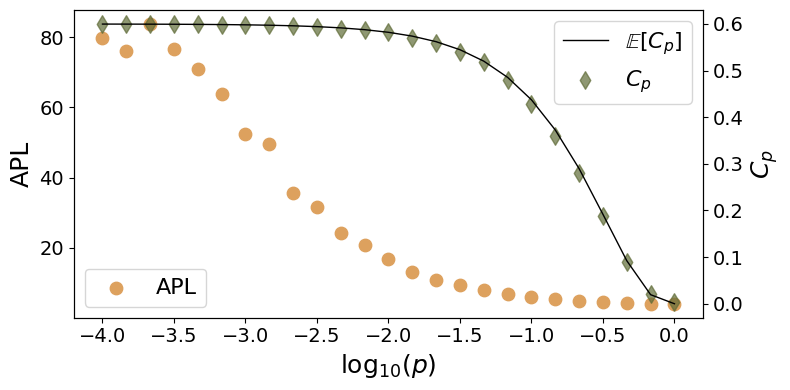

In [25]:
fig, ax1 = plt.subplots(1,1, figsize = (8, 4))

ax1.scatter(np.log10(pv), L_, color = '#dda15e', s = 80, label = 'APL')
ax1.set_xlabel(r'${\rm log}_{10}(p)$', fontsize = 18)
ax1.set_ylabel('APL', fontsize = 18)
ax1.tick_params(axis='both', which='major', labelsize = 14)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

ax2.plot(np.log10(pv), 3/2*(k-1)/(2*k-1)*(1-pv)**3, color = 'k', linewidth = 1, label = r'$\mathbb{E}[C_p]$')
ax2.scatter(np.log10(pv), C_, color = '#606c38', s = 80, marker = 'd', alpha = 0.7, label = r'$C_p$')
ax2.set_ylabel(r'$C_p$', fontsize = 18)
ax2.tick_params(axis='both', which='major', labelsize = 14)

ax1.legend(loc = 3, fontsize = 16)
ax2.legend(loc = 1, fontsize = 16)

plt.tight_layout()
# plt.savefig(f'{fig_directory}WS_APL_C.pdf', bbox_inches = 'tight', dpi = 400)
plt.show();